In [1]:
!pip install tensorflow==2.10.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 51.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0

In [2]:
import os
import cv2
import re
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.image as mpimg
from glob import glob
from tqdm import tqdm
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, UpSampling2D, AveragePooling2D, MaxPooling2D, LeakyReLU, concatenate
from tensorflow.keras.layers import Flatten, Dense, MaxPool2D, ReLU, BatchNormalization, Concatenate, Lambda, Activation, Dropout, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping

2023-08-10 19:00:25.809958: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutexC1Ev']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-package

In [3]:
print(tf.__version__)
print(np.__version__)
print(cv2.__version__)

2.10.1
1.23.5
4.8.0


In [4]:
#Global variable
BATCH_SIZE = 16
W,H = 256, 256
CHANNEL = 3
lr = 1e-5
epochs = 50

In [5]:
model_path = "u2net_for_skull_stripping.h5"
csv_path = "u2net_for_skull_stripping.csv"
path = "/kaggle/input/skull-stripping/temp"
split = 0.1

# Evaluation Metrics

In [6]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection  + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# Utility Function for Data Processing

In [7]:
#load dataset
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images/*")), key=lambda x: int(re.search(r'\d+', x).group()))
    masks = sorted(glob(os.path.join(path, "mask/*")), key=lambda x: int(re.search(r'\d+', x).group()))

    return images, masks

In [8]:
#create folder for save augmented images
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [9]:
#process image function
def read_img(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (256, 256))
    img = img / 255
    img = img.astype(np.float32)
    return img

#process mask function
def read_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask = mask / 255
    mask = np.expand_dims(mask, axis=-1)
    mask = mask.astype(np.float32)
    return mask

In [10]:
#enable to apply cv
def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        x = read_img(x)
        y = read_mask(y)
        return x, y

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    image.set_shape([256, 256, 3])
    mask.set_shape([256, 256, 1])

    return image, mask

In [11]:
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

# Model | U2Net

In [12]:
def conv_block(inputs, out_ch, rate=1):
    x = Conv2D(out_ch, 3, padding='same', dilation_rate=1)(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [13]:
def RSU_L(inputs, out_ch, int_ch, num_layers, rate=2):
    #initial convolution 
    x = conv_block(inputs, out_ch)
    init_feature = x
    
    #Encoder    
    skip_connection = []
    x = conv_block(x, int_ch)
    skip_connection.append(x)
    
    for i in range(num_layers-2):
        x = MaxPool2D((2,2))(x)
        x = conv_block(x, int_ch)
        skip_connection.append(x)
    
    #bridge
    b = conv_block(x, int_ch, rate=rate)
        
    #Decoder
    skip_connection.reverse()
    
    x = Concatenate()([b, skip_connection[0]])
    x = conv_block(x, int_ch)
    
    for i in range(num_layers-3):
        x = UpSampling2D((2,2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connection[i+1]])
        x = conv_block(x, int_ch)
        
    x = UpSampling2D((2,2), interpolation='bilinear')(x)
    x = Concatenate()([x, skip_connection[-1]])
    x = conv_block(x, out_ch)
    
    #Add
    x = Add()([x, init_feature])
    return x

In [14]:
#Dilated Residual U-Block
def RSU_4F(inputs, out_ch, int_ch):
    x0 = conv_block(inputs, out_ch, rate=1)
    
    #encoder
    x1 = conv_block(x0, int_ch, rate=1)
    x2 = conv_block(x1, int_ch, rate=2)
    x3 = conv_block(x2, int_ch, rate=4)
    
    x4 = conv_block(x3, int_ch, rate=8)
    
    #Decoder
    x = Concatenate()([x4, x3])
    x = conv_block(x, int_ch, rate=4)
    
    x = Concatenate()([x, x2])
    x = conv_block(x, int_ch, rate=2)
    
    x = Concatenate()([x, x1])
    x = conv_block(x, out_ch, rate=1)
    
    x = Add()([x, x0])
    return x

In [15]:
def u2net(input_shape, out_ch, int_ch, num_classes=1):
    inputs = Input(input_shape)
    s0 = inputs
    
    #Encoder
    s1 = RSU_L(s0, out_ch[0], int_ch[0], 7)
    p1 = MaxPool2D((2,2))(s1)
    
    s2 = RSU_L(p1, out_ch[1], int_ch[1], 6)
    p2 = MaxPool2D((2,2))(s2)
    
    s3 = RSU_L(p2, out_ch[2], int_ch[2], 5)
    p3 = MaxPool2D((2,2))(s3)
    
    s4 = RSU_L(p3, out_ch[3], int_ch[3], 4)
    p4 = MaxPool2D((2,2))(s4)
    
    s5 = RSU_4F(p4, out_ch[4], int_ch[4])
    p5 = MaxPool2D((2,2))(s5)
    
    #Bridge
    b1 = RSU_4F(p5, out_ch[5], int_ch[5])
    b2 = UpSampling2D((2,2), interpolation='bilinear')(b1)
    
    #Decoder
    d1 = Concatenate()([b2, s5])
    d1 = RSU_4F(d1, out_ch[6], int_ch[6])
    u1 = UpSampling2D((2,2), interpolation='bilinear')(d1)
    
    d2 = Concatenate()([u1, s4])
    d2 = RSU_L(d2, out_ch[7], int_ch[7], 4)
    u2 = UpSampling2D((2,2), interpolation='bilinear')(d2)
    
    d3 = Concatenate()([u2, s3])
    d3 = RSU_L(d3, out_ch[8], int_ch[8], 5)
    u3 = UpSampling2D((2,2), interpolation='bilinear')(d3)
    
    d4 = Concatenate()([u3, s2])
    d4 = RSU_L(d4, out_ch[9], int_ch[9], 6)
    u4 = UpSampling2D((2,2), interpolation='bilinear')(d4)
    
    d5 = Concatenate()([u4, s1])
    d5 = RSU_L(d5, out_ch[10], int_ch[10], 7)
    
    #Side Outputs
    y1 = Conv2D(num_classes, 3, padding='same')(d5)
    
    y2 = Conv2D(num_classes, 3, padding='same')(d4)
    y2 = UpSampling2D((2,2), interpolation='bilinear')(y2)
    
    y3 = Conv2D(num_classes, 3, padding='same')(d3)
    y3 = UpSampling2D((4,4), interpolation='bilinear')(y3)
    
    y4 = Conv2D(num_classes, 3, padding='same')(d2)
    y4 = UpSampling2D((8,8), interpolation='bilinear')(y4)
    
    y5 = Conv2D(num_classes, 3, padding='same')(d1)
    y5 = UpSampling2D((16,16), interpolation='bilinear')(y5)
    
    y6 = Conv2D(num_classes, 3, padding='same')(b1)
    y6 = UpSampling2D((32,32), interpolation='bilinear')(y6)
    
    y0 = Concatenate()([y1, y2, y3, y4, y5, y6])
    y0 = Conv2D(num_classes, 3, padding='same')(y0)
    
    y0 = Activation("sigmoid")(y0)
    y1 = Activation("sigmoid")(y1)
    y2 = Activation("sigmoid")(y2)
    y3 = Activation("sigmoid")(y3)
    y4 = Activation("sigmoid")(y4)
    y5 = Activation("sigmoid")(y5)
    y6 = Activation("sigmoid")(y6)
    
    model = Model(inputs, outputs=[y0,y1,y2,y3,y4,y5,y6])
    return model

In [16]:
def build_u2net(input_shape, num_classes=1):
    out_ch = [64, 128, 256, 512, 512, 512, 512, 256, 128, 64, 64]
    int_ch = [32, 32, 64, 128, 256, 256, 256, 128, 64, 32, 16]
    model = u2net(input_shape, out_ch, int_ch, num_classes=num_classes)
    return model

In [17]:
def build_u2net_lite(input_shape, num_classes=1):
    out_ch = [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64]
    int_ch = [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
    model = u2net(input_shape, out_ch, int_ch, num_classes=num_classes)
    return model

In [18]:
model = build_u2net((256, 256, 3))

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [20]:
metrics = [dice_coef, iou, Recall(), Precision()]
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=Adam(lr), metrics=metrics)

# Data Preprocessing

In [21]:
images, masks = load_data(path)
print(f'image: {len(images)} - Masks: {len(masks)}')

image: 722 - Masks: 722


In [22]:
train_image = images
train_masks = masks
test_image = images[700:]
test_masks = masks[700:]
print(f'image: {len(train_image)} - Masks: {len(train_masks)}')
print(f'image: {len(test_image)} - Masks: {len(test_masks)}')

image: 722 - Masks: 722
image: 22 - Masks: 22


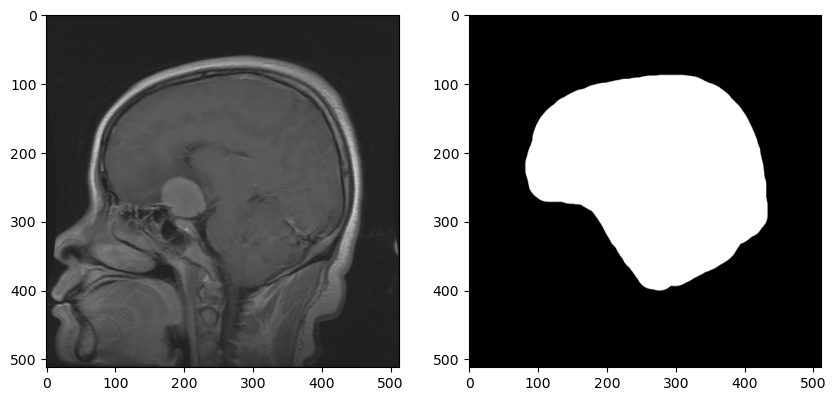

In [23]:
n = 200
img = cv2.imread(train_image[n], cv2.IMREAD_COLOR)
msk = cv2.imread(train_masks[n], cv2.IMREAD_COLOR)

fig, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(img)
ax[1].imshow(msk)

In [24]:
#convert dataset into tf dataset
train_dataset = tf_dataset(train_image, train_masks, batch=BATCH_SIZE)
test_dataset = tf_dataset(test_image, test_masks, batch=BATCH_SIZE)

In [25]:
#Callbacks
Callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True), 
    CSVLogger(csv_path),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7, verbose=1)
]

# Training

In [26]:
#training
model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset, 
    callbacks=Callbacks
    )

Epoch 1/50
46/46 [==============================] - ETA: 0s - loss: 4.4683 - activation_112_loss: 0.8840 - activation_113_loss: 1.0500 - activation_114_loss: 0.5080 - activation_115_loss: 0.5701 - activation_116_loss: 0.4336 - activation_117_loss: 0.2780 - activation_118_loss: 0.7447 - activation_112_dice_coef: 0.2878 - activation_112_iou: 0.1685 - activation_112_recall: 0.4016 - activation_112_precision: 0.1862 - activation_113_dice_coef: 0.4170 - activation_113_iou: 0.2642 - activation_113_recall: 0.9344 - activation_113_precision: 0.2710 - activation_114_dice_coef: 0.5573 - activation_114_iou: 0.3929 - activation_114_recall: 0.9193 - activation_114_precision: 0.5175 - activation_115_dice_coef: 0.4352 - activation_115_iou: 0.2786 - activation_115_recall: 0.7365 - activation_115_precision: 0.4741 - activation_116_dice_coef: 0.6324 - activation_116_iou: 0.4747 - activation_116_recall: 0.9494 - activation_116_precision: 0.5627 - activation_117_dice_coef: 0.6379 - activation_117_iou: 0.4

# Prediction

In [27]:
path = "/kaggle/working/predicted"
create_dir(path)

In [28]:
for img, msk in tqdm(zip(test_image, test_masks), total=len(test_image)):
    image_name = img.split("/")[-1]

    ori_x = cv2.imread(img, cv2.IMREAD_COLOR)
    ori_x = cv2.resize(ori_x, (W,H))
    x = ori_x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)

    ori_y = cv2.imread(msk, cv2.IMREAD_GRAYSCALE)
    ori_y = cv2.resize(ori_y, (W,H))
    ori_y = np.expand_dims(ori_y, axis=-1)

    y_pred = model.predict(x)[0] > 0.5  
    y_pred = y_pred.astype(np.int32)
    y_pred = y_pred.reshape(256, 256, 1)

    print(ori_x.shape, ori_y.shape, y_pred.shape)
    save_image_path = f"/kaggle/working/predicted/{image_name}"

    sep_line = np.ones((H, 10, 3)) * 255
    cat_image = np.concatenate([ori_y, y_pred*255], axis=1)
    cv2.imwrite(save_image_path, cat_image)

  0%|          | 0/22 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


  5%|▍         | 1/22 [00:03<01:13,  3.48s/it]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 40ms/step


  9%|▉         | 2/22 [00:03<00:30,  1.51s/it]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 41ms/step


 14%|█▎        | 3/22 [00:03<00:16,  1.15it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 40ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 5/22 [00:03<00:07,  2.33it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 6/22 [00:04<00:05,  2.91it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 7/22 [00:04<00:04,  3.53it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 45ms/step


 36%|███▋      | 8/22 [00:04<00:03,  4.33it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 41ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 10/22 [00:04<00:02,  5.66it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 41ms/step


 50%|█████     | 11/22 [00:04<00:01,  5.85it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 38ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 13/22 [00:04<00:01,  7.27it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 39ms/step


 64%|██████▎   | 14/22 [00:04<00:01,  7.40it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 40ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 16/22 [00:05<00:00,  7.89it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 42ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 18/22 [00:05<00:00,  8.61it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 42ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 40ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)


 91%|█████████ | 20/22 [00:05<00:00,  9.16it/s]

1/1 [==============================] - 0s 42ms/step
(256, 256, 3) (256, 256, 1) (256, 256, 1)
1/1 [==============================] - 0s 39ms/step


100%|██████████| 22/22 [00:05<00:00,  3.79it/s]

(256, 256, 3) (256, 256, 1) (256, 256, 1)


Text(0.5, 0, 'truth                                     predicted')

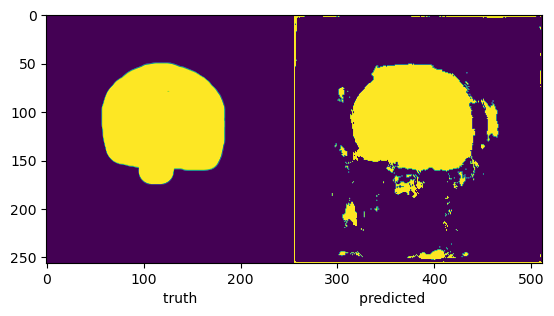

In [29]:
i = "/kaggle/working/predicted/709.png"
i = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
plt.imshow(i)
plt.xlabel("truth                                     predicted")

In [30]:
t_path = "/kaggle/working/"
image_folder = sorted(glob(os.path.join(t_path, "predicted/*")))

# Visualization

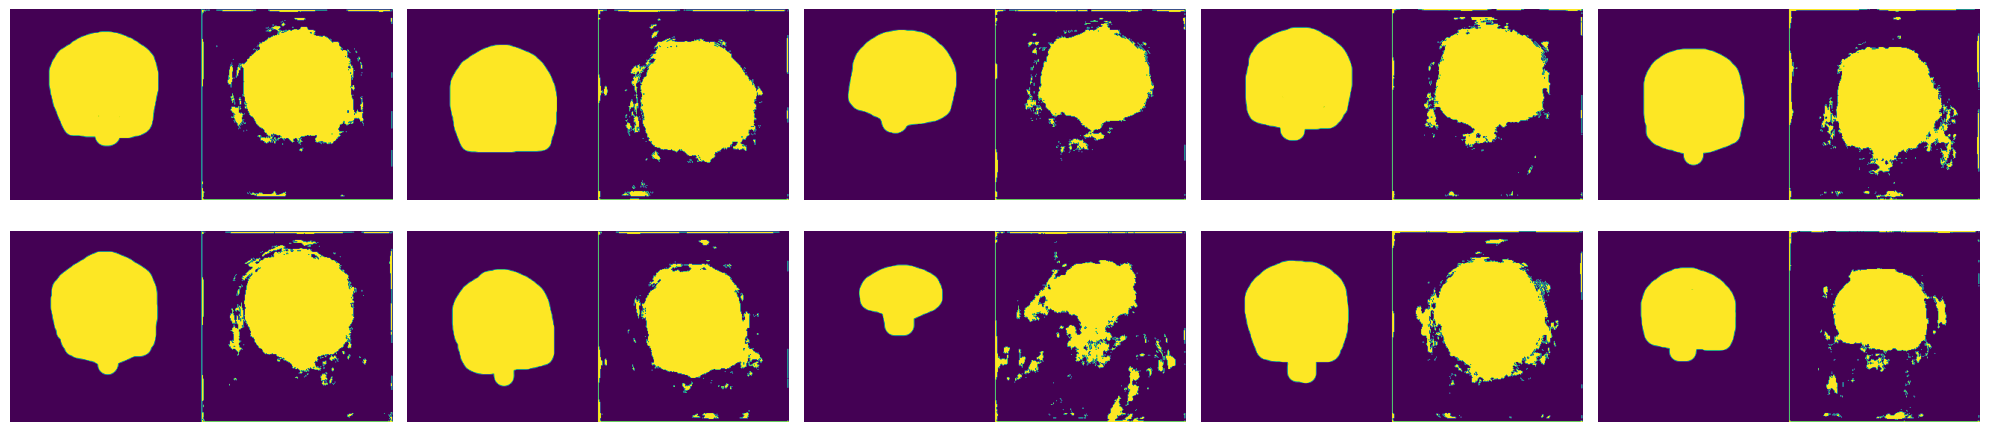

In [31]:
rows = 2
columns = 5

# Create a figure and axis objects
fig, axes = plt.subplots(rows, columns, figsize=(20, 5))

# Flatten the axes array to iterate through it easily
axes = axes.flatten()

# Loop through the images and display them
for i, ax in enumerate(axes):
    # Check if there are more images than needed for the grid
    if i < len(image_folder):
        # Read the image file
        image = mpimg.imread(image_folder[i])
        # Display the image
        ax.imshow(image)
        ax.axis("off")
    else:
        # If there are no more images, hide the remaining axes
        ax.axis("off")

# Adjust the spacing between the subplots
plt.tight_layout()

# Show the plot
plt.show()

# Skull Stripping

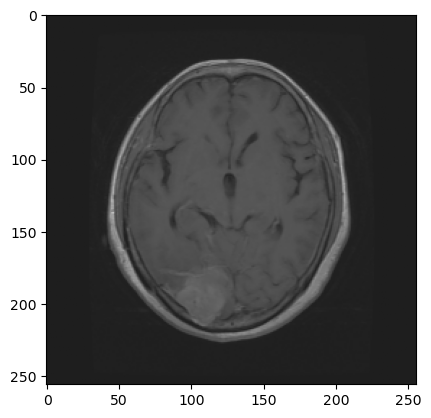

In [32]:
test_img_path = train_image[609]
test_img_mask = train_masks[609]
test_img = read_img(test_img_path)
test_msk = read_mask(test_img_mask)
plt.imshow(test_img)

In [33]:
img = test_img.reshape(1, 256, 256, 3)
img.shape

(1, 256, 256, 3)

In [34]:
pred = model.predict(img)[0] > 0.5  
pred = pred.astype(np.int32)
pred_img = pred.reshape(256, 256, 1)

1/1 [==============================] - 0s 40ms/step


Text(0.5, 0, 'PREDICTED MASK')

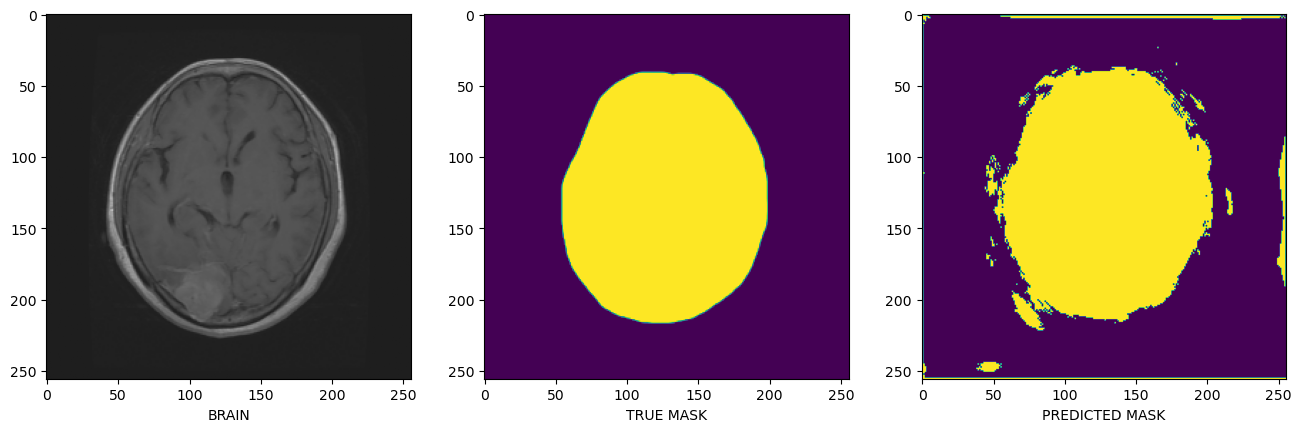

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(16,8))
ax[0].imshow(test_img)
ax[0].set_xlabel("BRAIN")
ax[1].imshow(test_msk)
ax[1].set_xlabel("TRUE MASK")
ax[2].imshow(pred_img)
ax[2].set_xlabel("PREDICTED MASK")

In [36]:
#save the predicted mask image
cv2.imwrite("/kaggle/working/mask-1.png", pred_img)

True

In [37]:
#read mask again
maskImg = cv2.imread("/kaggle/working/mask-1.png")
print(maskImg.shape)
maskImg = cv2.cvtColor(maskImg, cv2.COLOR_BGR2GRAY)
maskImg.shape

(256, 256, 3)


(256, 256)

In [38]:
# Bitwise AND the masked brain image with the masked image to remove the skull
masked = cv2.bitwise_and(test_img, test_img, mask=maskImg)

Text(0.5, 0, 'SKULL STRIPPED BRAIN')

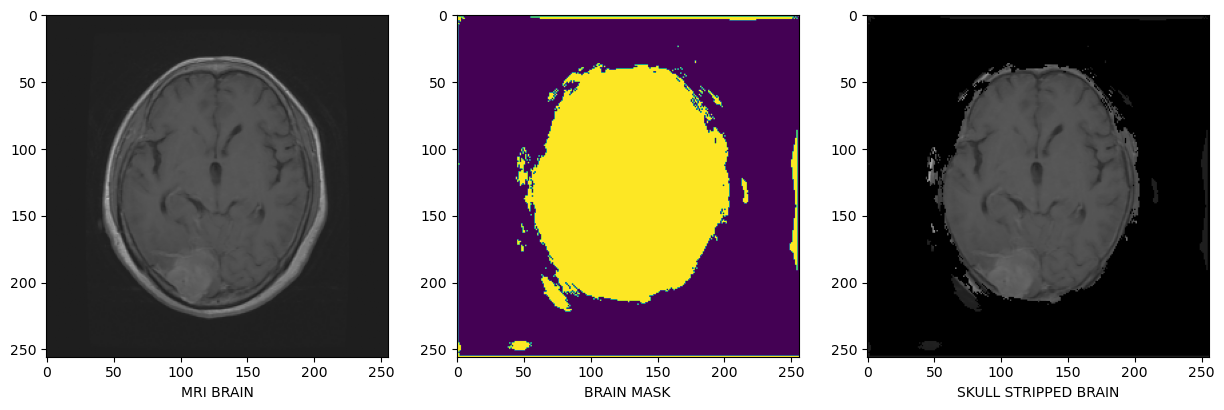

In [39]:
#visualize
fig, ax = plt.subplots(1, 3, figsize=(15, 12))
ax[0].imshow(test_img)
ax[0].set_xlabel("MRI BRAIN")
ax[1].imshow(maskImg)
ax[1].set_xlabel("BRAIN MASK")
ax[2].imshow(masked)
ax[2].set_xlabel("SKULL STRIPPED BRAIN")